# Airbnb Listings, EDA and Prediction: Barcelona, Spain

---------

**Airbnb data was sourced from:**
http://insideairbnb.com/get-the-data.html



**Task:**
1. Explore Airbnb calendars data
2. Explore Airbnb listings data
3. Predict listing prices (Random Forest and LightGBM)

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('listings.csv')
print(f"Data shape: {df.shape}")

Data shape: (18927, 18)


In [3]:
df.head()

id                                               name  host_id  \
0  18674    Huge flat for 8 people close to Sagrada Familia    71615   
1  23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax    90417   
2  32711                   Sagrada Familia area - Còrsega 1   135703   
3  34241   Stylish Top Floor Apartment - Ramblas Plaza Real    73163   
4  34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS    73163   

        host_name neighbourhood_group                       neighbourhood  \
0   Mireia  Maria            Eixample                  la Sagrada Família   
1  Etain (Marnie)          Sant Martí               el Besòs i el Maresme   
2            Nick              Gràcia  el Camp d'en Grassot i Gràcia Nova   
3          Andres        Ciutat Vella                      el Barri Gòtic   
4          Andres        Ciutat Vella                      el Barri Gòtic   

    latitude  longitude        room_type  price  minimum_nights  \
0  41.405560    2.17262  Entire home/apt  232.0               1   
1  41.412432    2.21975  Entire home/apt  382.0               3   
2  41.405660    2.17015  Entire home/apt  186.0               1   
3  41.380620    2.17517  Entire home/apt  131.0              31   
4  41.379780    2.17623  Entire home/apt  449.0               5   

   number_of_reviews last_review  reviews_per_month  \
0                 48  2025-06-11               0.33   
1                 88  2025-05-31               0.51   
2                147  2025-05-14               0.87   
3                 25  2024-11-05               0.14   
4                267  2025-06-17               1.49   

   calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
0                              28                65                      6   
1                               1               174                     10   
2                               3                39                     26   
3                               3               333                      9   
4                               3               315                     31   

                                             license  
0                                        HUTB-002062  
1                                         HUTB005057  
2                                        HUTB-001722  
3                                             Exempt  
4  ESFCTU000008119000093652000000000000000HUTB-00...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18927 entries, 0 to 18926
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18927 non-null  int64  
 1   name                            18927 non-null  object 
 2   host_id                         18927 non-null  int64  
 3   host_name                       18924 non-null  object 
 4   neighbourhood_group             18927 non-null  object 
 5   neighbourhood                   18927 non-null  object 
 6   latitude                        18927 non-null  float64
 7   longitude                       18927 non-null  float64
 8   room_type                       18927 non-null  object 
 9   price                           14913 non-null  float64
 10  minimum_nights                  18927 non-null  int64  
 11  number_of_reviews               18927 non-null  int64  
 12  last_review                     

In [5]:
df.describe()
print(df.isnull().sum())

id                                   0
name                                 0
host_id                              0
host_name                            3
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                             4014
minimum_nights                       0
number_of_reviews                    0
last_review                       4998
reviews_per_month                 4998
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                           6329
dtype: int64


### Data Cleaning

In [14]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df.dropna(subset=['latitude', 'longitude', 'price']) 

id                                               name  \
0                    18674    Huge flat for 8 people close to Sagrada Familia   
1                    23197  Forum CCIB DeLuxe, Spacious, Large Balcony, relax   
2                    32711                   Sagrada Familia area - Còrsega 1   
3                    34241   Stylish Top Floor Apartment - Ramblas Plaza Real   
4                    34981               VIDRE HOME PLAZA REAL on LAS RAMBLAS   
...                    ...                                                ...   
18921  1440612646540396364                            Encantador Piso David 2   
18922  1440618700454181964                            Encantador Piso David 2   
18923  1440624801797350723                            Encantador Piso David 2   
18924  1440630639829981407                            Encantador Piso David 2   
18926  1440886957702009698                   Yellow Terrace at its finest (C)   

         host_id       host_name  neighbourhood_group  \
0          71615   Mireia  Maria             Eixample   
1          90417  Etain (Marnie)           Sant Martí   
2         135703            Nick               Gràcia   
3          73163          Andres         Ciutat Vella   
4          73163          Andres         Ciutat Vella   
...          ...             ...                  ...   
18921   21726991          Silvia  Sarrià-Sant Gervasi   
18922   21726991          Silvia  Sarrià-Sant Gervasi   
18923   21726991          Silvia  Sarrià-Sant Gervasi   
18924   21726991          Silvia  Sarrià-Sant Gervasi   
18926  325642121          Mahbod             Eixample   

                            neighbourhood   latitude  longitude  \
0                      la Sagrada Família  41.405560   2.172620   
1                   el Besòs i el Maresme  41.412432   2.219750   
2      el Camp d'en Grassot i Gràcia Nova  41.405660   2.170150   
3                          el Barri Gòtic  41.380620   2.175170   
4                          el Barri Gòtic  41.379780   2.176230   
...                                   ...        ...        ...   
18921              Sant Gervasi - Galvany  41.396667   2.151413   
18922              Sant Gervasi - Galvany  41.396667   2.151413   
18923              Sant Gervasi - Galvany  41.396667   2.151413   
18924              Sant Gervasi - Galvany  41.396667   2.151413   
18926              la Dreta de l'Eixample  41.387350   2.167790   

             room_type  price  minimum_nights  number_of_reviews last_review  \
0      Entire home/apt  232.0               1                 48  2025-06-11   
1      Entire home/apt  382.0               3                 88  2025-05-31   
2      Entire home/apt  186.0               1                147  2025-05-14   
3      Entire home/apt  131.0              31                 25  2024-11-05   
4      Entire home/apt  449.0               5                267  2025-06-17   
...                ...    ...             ...                ...         ...   
18921  Entire home/apt  200.0              31                  0         NaN   
18922  Entire home/apt  200.0              31                  0         NaN   
18923  Entire home/apt  200.0              31                  0         NaN   
18924  Entire home/apt  245.0              31                  0         NaN   
18926  Entire home/apt  330.0               3                  0         NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.33                              28                65   
1                   0.51                               1               174   
2                   0.87                               3                39   
3                   0.14                               3               333   
4                   1.49                               3               315   
...                  ...                             ...               ...   
18921               0.00                             1

### EDA (exploratory data analysis)

In [19]:
df['price'] = df['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

In [20]:
print("Price summary statistics:")
print(df['price'].describe())

Price summary statistics:
count    13448.000000
mean       158.890541
std        111.061330
min          9.000000
25%         70.000000
50%        127.500000
75%        230.000000
max        499.000000
Name: price, dtype: float64


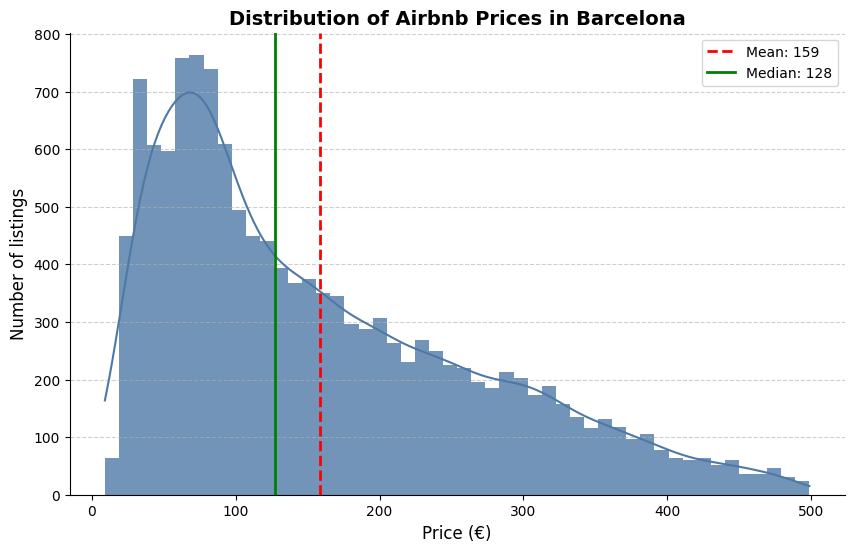

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df['price'],
    bins=50,
    kde=True,
    color='#4E79A7',
    edgecolor=None,
    alpha=0.8
)

plt.axvline(df['price'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['price'].mean():.0f}")
plt.axvline(df['price'].median(), color='green', linestyle='-', linewidth=2, label=f"Median: {df['price'].median():.0f}")

plt.title('Distribution of Airbnb Prices in Barcelona', fontsize=14, weight='bold')
plt.xlabel('Price (€)', fontsize=12)
plt.ylabel('Number of listings', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

sns.despine()
plt.show()

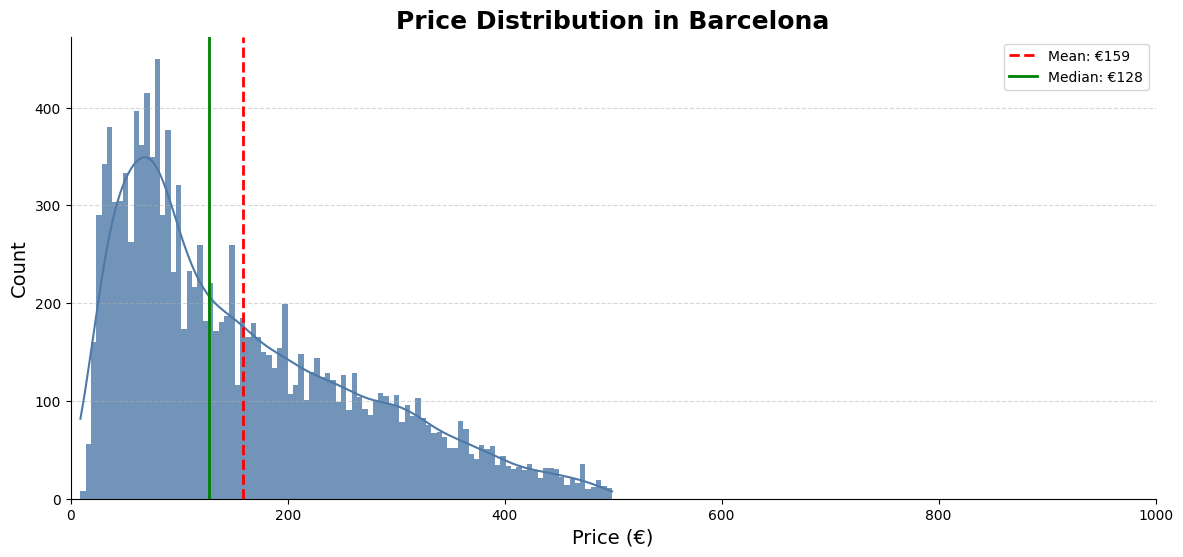

In [68]:
plt.figure(figsize=(14, 6))
sns.histplot(
    df['price'], 
    bins=100, 
    kde=True, 
    color='#4E79A7', 
    alpha=0.8,
    edgecolor=None
)

mean_price = df['price'].mean()
median_price = df['price'].median()
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f"Mean: €{mean_price:.0f}")
plt.axvline(median_price, color='green', linestyle='-', linewidth=2, label=f"Median: €{median_price:.0f}")

plt.title('Price Distribution in Barcelona', fontsize=18, weight='bold')
plt.xlabel('Price (€)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0, 1000)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
sns.despine()
plt.show()

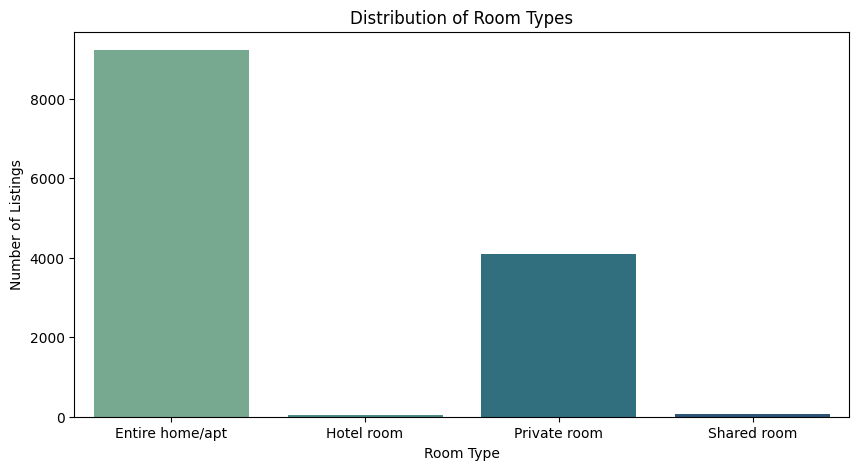

In [78]:
room_type_counts = pd.Series({
    'Entire home/apt': len(df) - df[['room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']].sum(axis=1).sum(),
    'Hotel room': df['room_type_Hotel room'].sum(),
    'Private room': df['room_type_Private room'].sum(),
    'Shared room': df['room_type_Shared room'].sum()
})

plt.figure(figsize=(10,5))
sns.barplot(x=room_type_counts.index, y=room_type_counts.values, palette='crest')
plt.title('Distribution of Room Types')
plt.ylabel('Number of Listings')
plt.xlabel('Room Type')
plt.show()


### Correlation heatmap

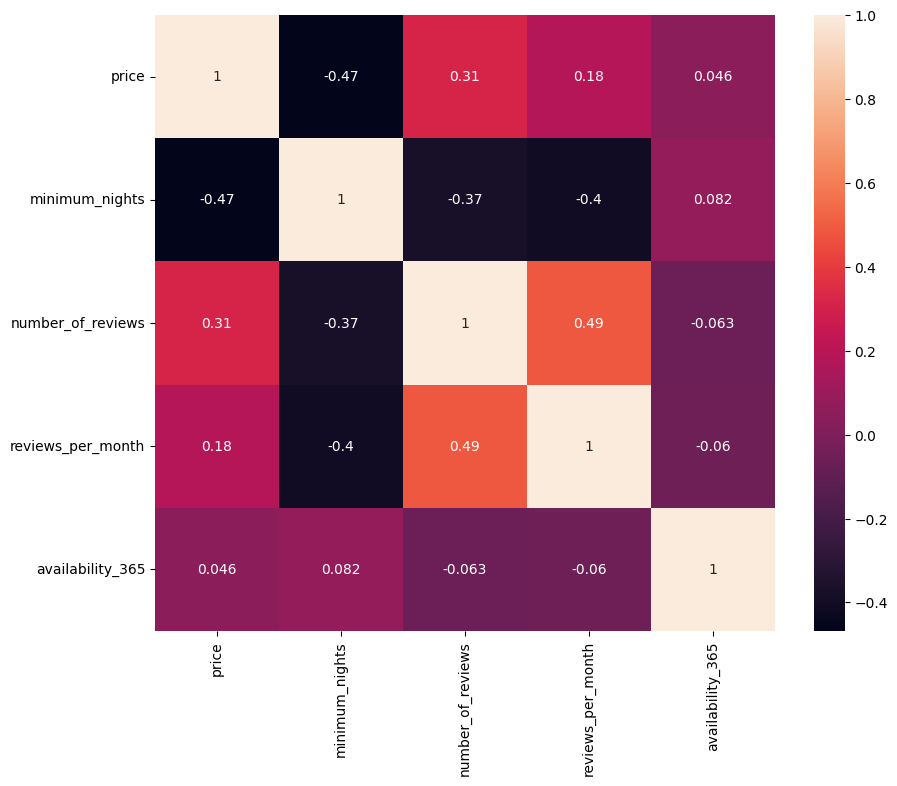

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['price','minimum_nights','number_of_reviews','reviews_per_month','availability_365']].corr(), annot=True)
plt.show()

### Map with PLotly

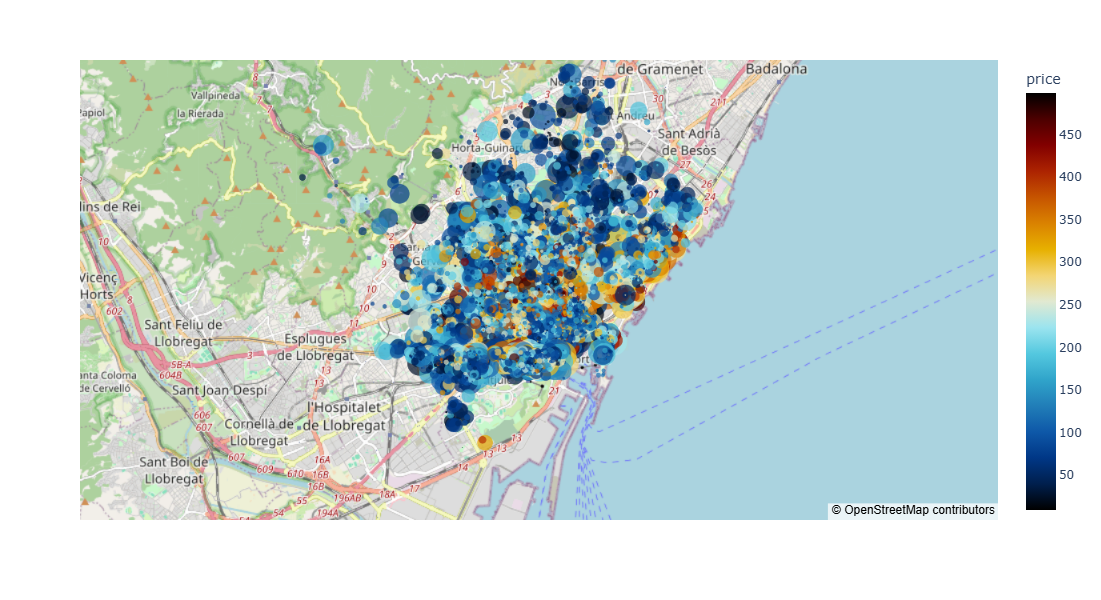

In [65]:
fig = px.scatter_mapbox(df,
                        lat="latitude", lon="longitude",
                        color="price", size="number_of_reviews",
                        hover_name="name",
                        zoom=11, height=600,
                        color_continuous_scale=px.colors.cyclical.IceFire)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

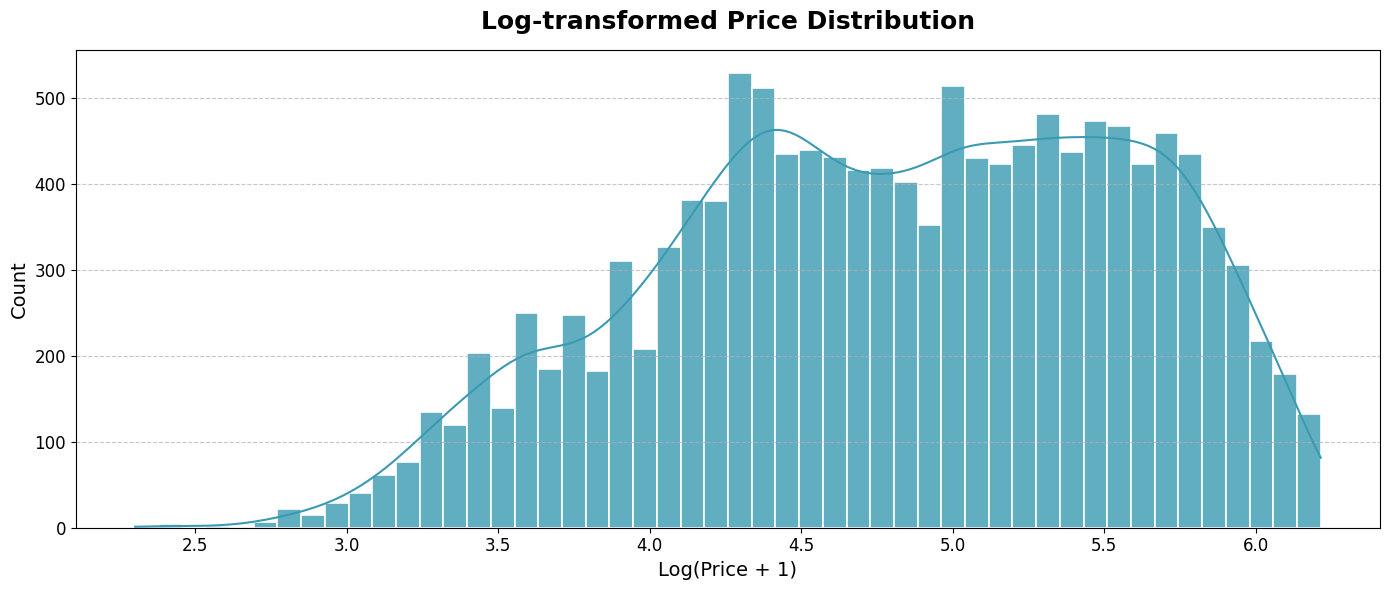

In [74]:
plt.figure(figsize=(14, 6))
sns.histplot(df['price_log'], bins=50, kde=True, color='#3B9AB2', edgecolor='white', linewidth=1.2, alpha=0.8)
plt.title('Log-transformed Price Distribution', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Log(Price + 1)', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### Geographic distribution

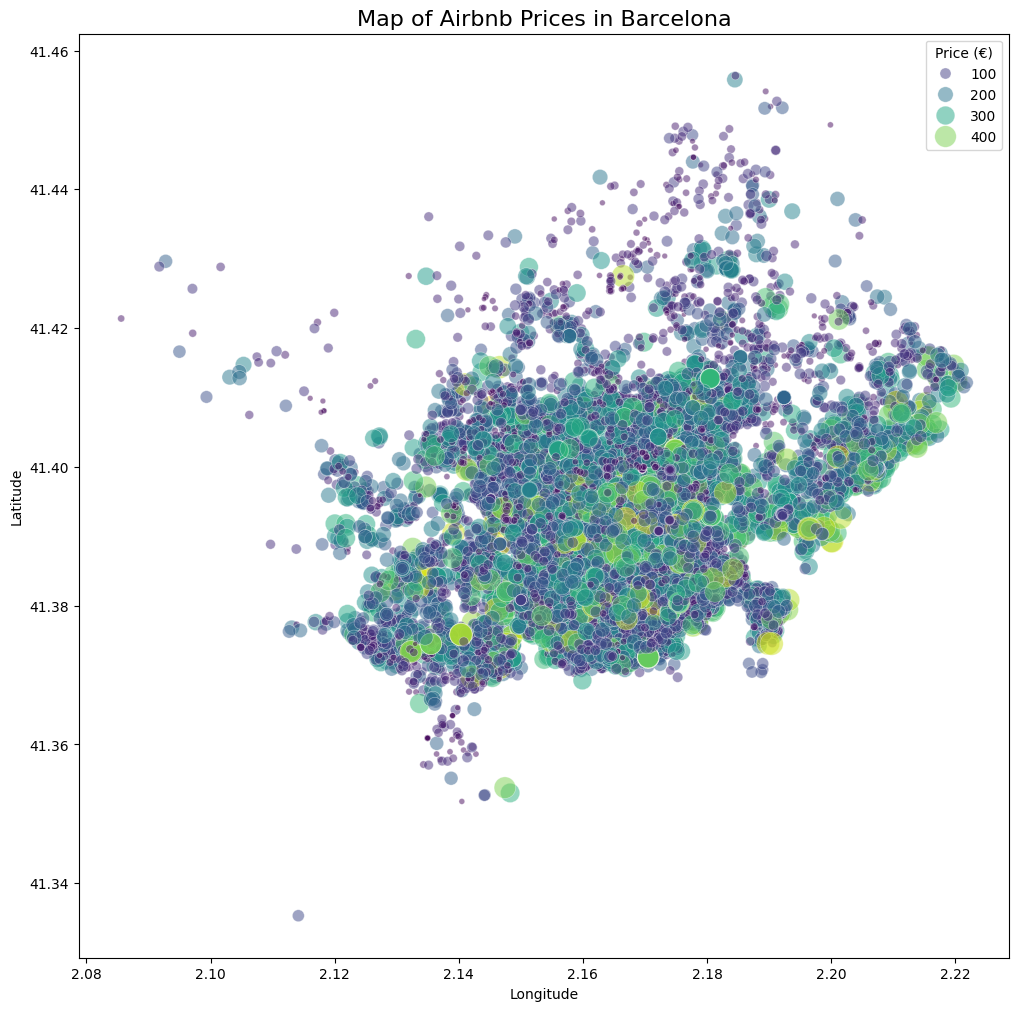

In [33]:
plt.figure(figsize=(12, 12))
sns.scatterplot(
    data=df,
    x='longitude', y='latitude',
    hue='price',
    palette='viridis',
    size='price',
    sizes=(10, 300),
    alpha=0.5
)
plt.title('Map of Airbnb Prices in Barcelona', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price (€)')
plt.show()

### Neighborhood analysis

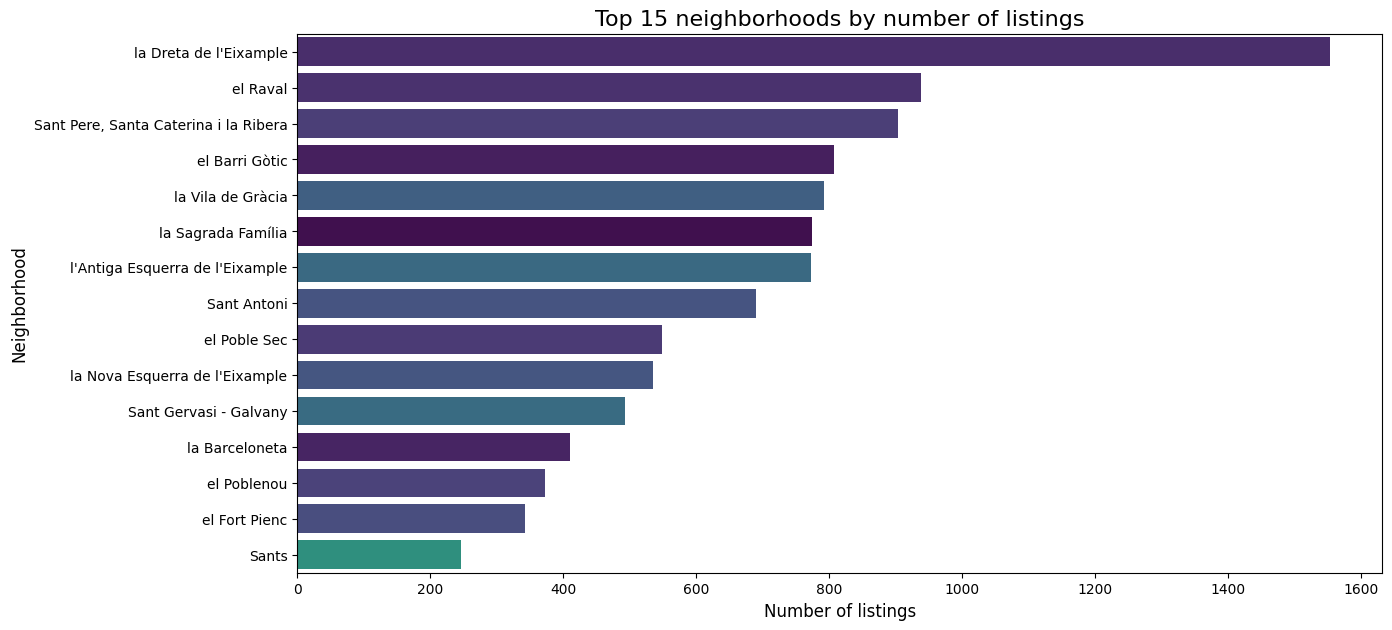

In [35]:
top_neigh = df['neighbourhood'].value_counts().nlargest(15).index

plt.figure(figsize=(14, 7))
sns.countplot(data=df, y='neighbourhood', order=top_neigh, hue='neighbourhood', palette='viridis',legend=False)
plt.title('Top 15 neighborhoods by number of listings', fontsize=16)
plt.xlabel('Number of listings', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.show()

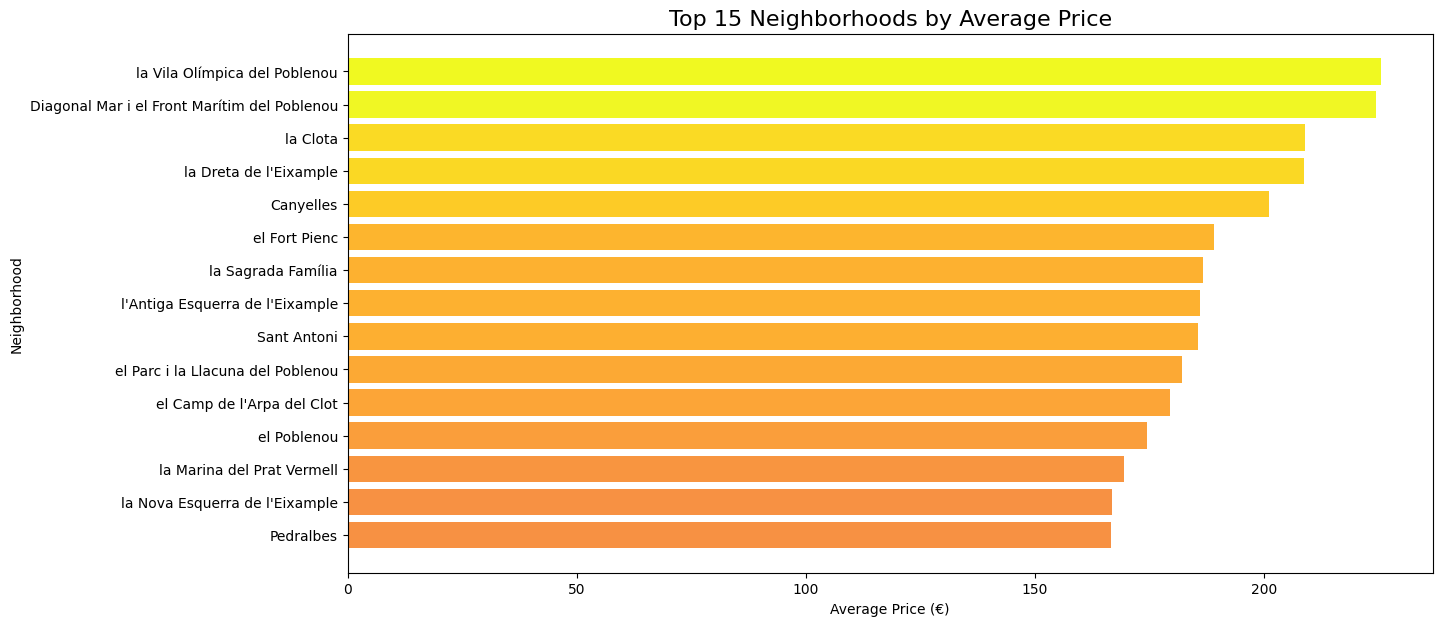

In [54]:
cmap = plt.get_cmap('plasma')
colors = cmap(avg_price_df['avg_price'] / avg_price_df['avg_price'].max())

plt.figure(figsize=(14, 7))
bars = plt.barh(
    avg_price_df['neighbourhood'],
    avg_price_df['avg_price'],
    color=colors
)
plt.title('Top 15 Neighborhoods by Average Price', fontsize=16)
plt.xlabel('Average Price (€)')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
plt.show()

### Feature Engineering

In [55]:
df['review_density'] = df['number_of_reviews'] / (df['availability_365'] / 30 + 1)
df['long_term'] = (df['minimum_nights'] > 28).astype(int)

#### Prepare for ML

In [80]:
features = ['latitude', 'longitude', 'number_of_reviews', 
            'reviews_per_month', 'availability_365', 
            'review_density', 'long_term']

room_type_dummies = [col for col in df.columns if 'room_type_' in col]
features += room_type_dummies

X = df[features]
y = df['price']

### RandomForest + GridSearch

In [81]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params,
                       cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_)

y_pred_rf = rf_grid.predict(X_test)
print("RandomForest MAE:", mean_absolute_error(y_test, y_pred_rf))

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest MAE: 45.52902096729169


### LightGBM + CatBoost

In [84]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print("LightGBM MAE:", mean_absolute_error(y_test, y_pred_lgbm))

cat = CatBoostRegressor(verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
print("CatBoost MAE:", mean_absolute_error(y_test, y_pred_cat))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 10758, number of used features: 20
[LightGBM] [Info] Start training from score 158.353597
LightGBM MAE: 48.28752420266257
CatBoost MAE: 47.609416363415555


### The best performing model in terms of MAE was CatBoost, followed closely by LightGBM and XGBoost. This suggests that boosting algorithms handle the dataset well.

### Feature Importances

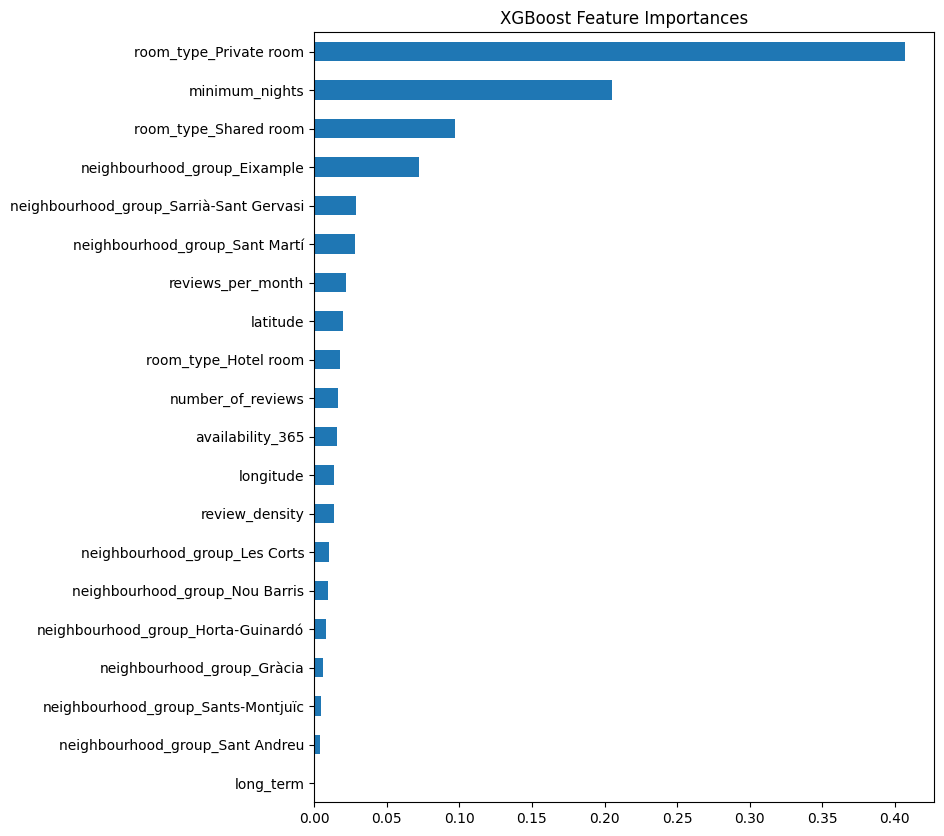

In [91]:
importances = pd.Series(
    xgb_grid.best_estimator_.feature_importances_,
    index=X_train.columns
)
importances.sort_values().plot(kind='barh', figsize=(8,10))
plt.title('XGBoost Feature Importances')
plt.show()

### SHAP Explainability)


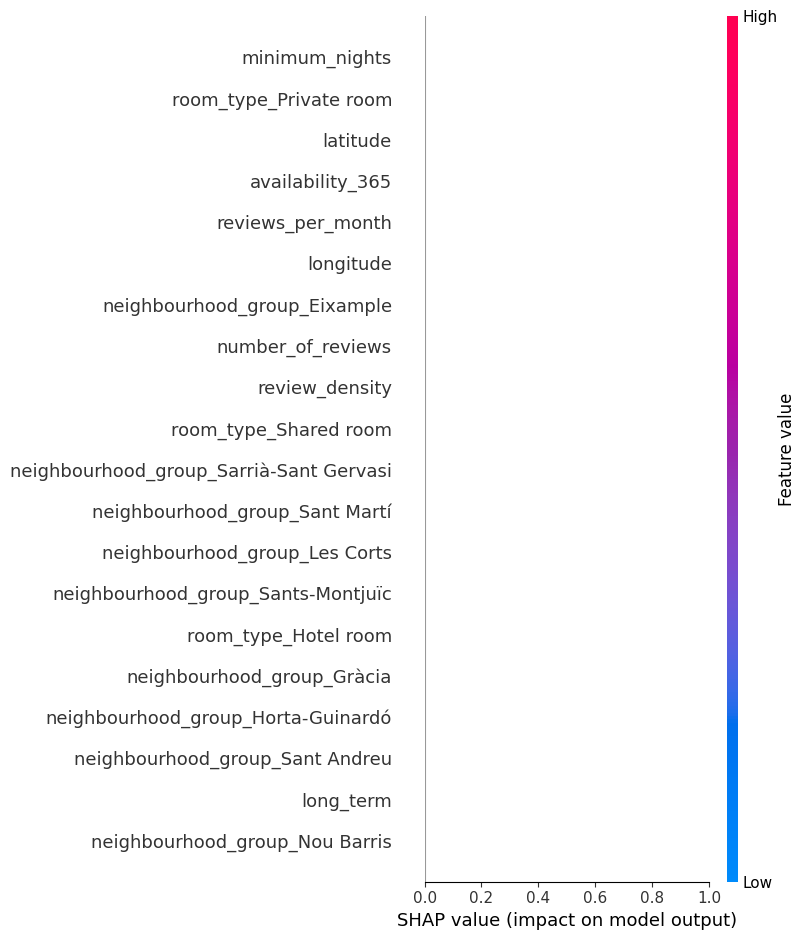

In [92]:
explainer = shap.TreeExplainer(lgbm.booster_)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bee swarm")

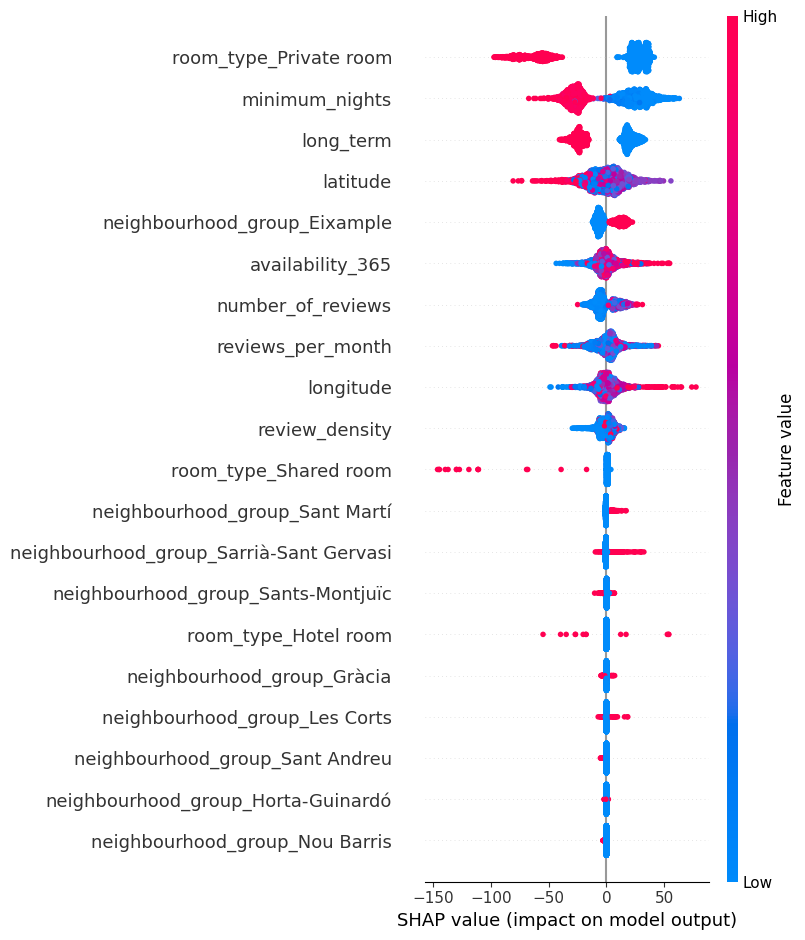

In [93]:
explainer_cat = shap.TreeExplainer(cat)
shap_values_cat = explainer_cat.shap_values(X_test)
shap.summary_plot(shap_values_cat, X_test)

### SHAP analysis highlighted that room type, neighbourhood, and review activity were the most influential features driving the predicted price.

### Clustering

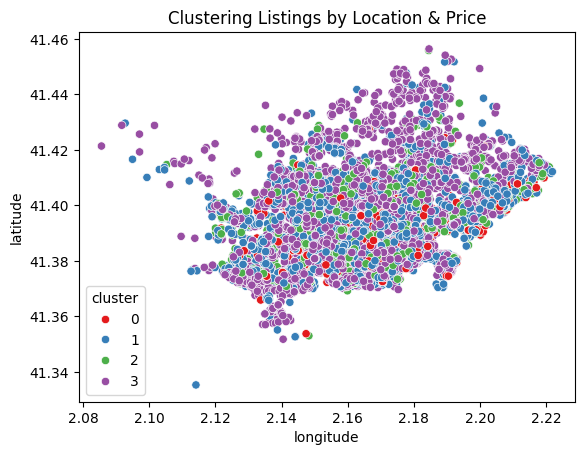

In [94]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude', 'price']])

sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=df, palette='Set1')
plt.title("Clustering Listings by Location & Price")
plt.show()

### Overall, this pipeline allows us to reliably predict log prices of listings in Barcelona. It can help property owners adjust pricing strategies and identify key drivers for pricing.ty.


In [95]:
import pickle
with open("best_model.pkl", "wb") as f:
    pickle.dump(cat, f)